# ProSmart Graph Hackathon 2022 - Provider Profiling Using Synthea Graph DB and Advanced Graph Neural Network Model

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pyTigerGraph as tg
import torch
from sklearn import preprocessing
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics.cluster import pair_confusion_matrix

In [2]:
import torch.nn.functional as F
from torch.optim import Adam
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import jaccard_score
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.nn import ARGVA, GCNConv
import matplotlib.cm as cm
import time
from sklearn.manifold import TSNE

Connect to Local Synthea DB. Please refer following link on how to create Synthea DB. 

Its open source please follow the link below to create Synthea on Tigergraph

https://github.com/TigerGraph-DevLabs/Synthea-Medgraph

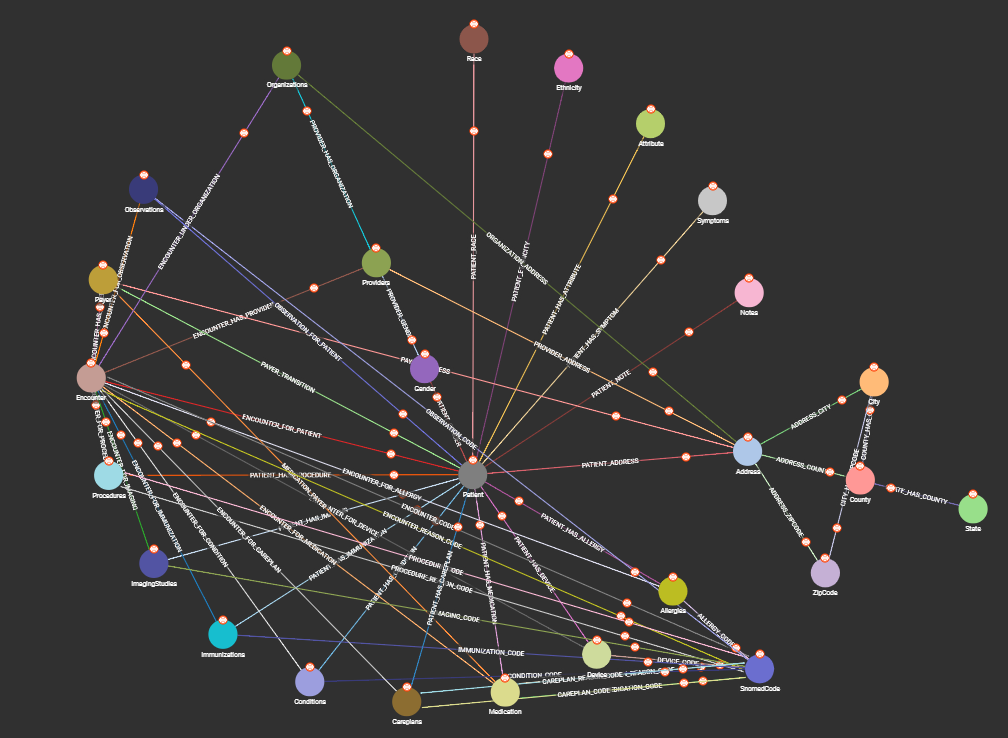

In [3]:
conn = tg.TigerGraphConnection(host='http://localhost', username='tigergraph', password='tigergraph',graphname='MedGraph')

In [4]:
le = preprocessing.LabelEncoder()

# Load Vertices in Python Environment

Provider Vertex

In [175]:
provider = conn.getVertexDataframe("Providers")
print(provider.shape[0])
provider.head(2)

1436


,v_id,provider_id,name,utilization,speciality
0,ff3559cc-6081-3eca-a573-3adcc69f1d8e,ff3559cc-6081-3eca-a573-3adcc69f1d8e,Keneth Hansen,65,GENERAL PRACTICE
1,103af4d8-367d-37ca-8403-213f3bd8b98c,103af4d8-367d-37ca-8403-213f3bd8b98c,Tobie D'Amore,5,GENERAL PRACTICE


In [176]:
v_id = provider.v_id
provider.shape

(1436, 5)

Encounter Vertex

In [177]:
encounter = conn.getVertexDataframe("Encounter")
print(encounter.shape[0])
encounter.head(2)

54647


,v_id,encounter_id,baseEncounterCost,totalClaimCost,payerCoverage,classType,startTime,endTime
0,72b2bde7-6c5e-43ca-8fa2-d3e6b4bf17fd,72b2bde7-6c5e-43ca-8fa2-d3e6b4bf17fd,166.30,166.30,91.30,ambulatory,2013-11-01 01:04:20,2013-11-01 01:46:20
1,214f98ca-4b6c-4531-bba4-10b79a652944,214f98ca-4b6c-4531-bba4-10b79a652944,211.54,211.54,151.54,ambulatory,1986-08-29 06:42:40,1986-08-29 07:34:40


Patient Vertex

In [178]:
patient = conn.getVertexDataframe("Patient")
print(patient.shape[0])
patient.head(2)

496


,v_id,patient_id,lastName,firstName,maiden,birthday,ssn,license,passport,healthcareExpense,healthcareCoverage,suffix,prefix,maritalStatus,birthplace
0,7a4c97cd-0f8f-4654-9130-c49c7fd6144c,7a4c97cd-0f8f-4654-9130-c49c7fd6144c,Adams,Joey,,2014-11-02 00:00:00,999-89-1716,,,17240.00,2390.52,,,,Alexandria Kentucky US
1,923bffd4-22ce-466f-b584-bf8600bf450a,923bffd4-22ce-466f-b584-bf8600bf450a,Rocha,Ricardo,,1956-03-30 00:00:00,999-20-5689,S99987406,X50055024X,1398459.59,69890.74,,Mr.,S,Panama City Panama PA


Medication Vertex

In [179]:
medication = conn.getVertexDataframe("Medication")
print(medication.shape[0])
medication.head(2)

20069


,v_id,medication_id,medication_code,description,startDate,endDate,baseCost,payerCoverage,dispenses,totalCost
0,20049,20049,197361,Amlodipine 5 MG Oral Tablet,2015-02-07 13:57:18,2016-02-13 13:57:18,6.84,0.0,12,82.08
1,20030,20030,309362,Clopidogrel 75 MG Oral Tablet,2011-01-15 13:57:18,2012-01-21 13:57:18,19.40,0.0,12,232.80


# Load Edges in Python Environment

Encounter_has_provider

In [10]:
encounter_has_provider = pd.DataFrame()
for i in encounter.v_id.values:
    edges = conn.getEdgesDataframe(sourceVertexType = 'Encounter', sourceVertexId = i, edgeType = 'ENCOUNTER_HAS_PROVIDER')
    encounter_has_provider = pd.concat([edges, encounter_has_provider],  ignore_index=True)

In [ ]:
print(encounter_has_provider.shape)
encounter_has_provider.head(2)

In [ ]:
#to save time during save the edge dataframe to csv
encounter_has_provider.to_csv('encounter_has_provider.csv')

In [10]:
encounter_has_provider = pd.read_csv('encounter_has_provider.csv')
encounter_has_provider=encounter_has_provider.drop('Unnamed: 0', axis=1)
encounter_has_provider.head(2)

,from_type,from_id,to_type,to_id
0,Encounter,3e117d5c-3ed2-472c-bab0-3f5da7d885d6,Providers,4a585d14-f015-3a63-95c1-40687e49d38b
1,Encounter,206f312b-510a-4d0c-915b-51e4d4ed99ee,Providers,cde0b058-b9c3-3e91-9053-508640c3ecdf


ENCOUNTER_FOR_PATIENT

In [ ]:
encounter_for_patient = pd.DataFrame()
for i in encounter.v_id.values:
    edges = conn.getEdgesDataframe(sourceVertexType = 'Encounter', sourceVertexId = i, edgeType = 'ENCOUNTER_FOR_PATIENT')
    encounter_for_patient = pd.concat([edges, encounter_for_patient],  ignore_index=True)

In [13]:
print(encounter_for_patient.shape)
encounter_for_patient.head(2)

In [14]:
#to save time during save the edge dataframe to csv
encounter_for_patient.to_csv('encounter_for_patient.csv')

In [11]:
encounter_for_patient = pd.read_csv('encounter_for_patient.csv')
encounter_for_patient=encounter_for_patient.drop('Unnamed: 0', axis=1)
encounter_for_patient.head(2)

,from_type,from_id,to_type,to_id
0,Encounter,3e117d5c-3ed2-472c-bab0-3f5da7d885d6,Patient,2e70bc07-303b-451f-8844-0613bb1c2e37
1,Encounter,206f312b-510a-4d0c-915b-51e4d4ed99ee,Patient,2e70bc07-303b-451f-8844-0613bb1c2e37


ENCOUNTER_FOR_MEDICATION

In [ ]:
encounter_for_medication = pd.DataFrame()
for i in medication.v_id.values:
    edges = conn.getEdgesDataframe(sourceVertexType = 'Medication', sourceVertexId = i,edgeType = 'ENCOUNTER_FOR_MEDICATION')
    encounter_for_medication = pd.concat([edges, encounter_for_medication],  ignore_index=True)

In [ ]:
print(encounter_for_medication.shape)
encounter_for_medication.head(2)

In [ ]:
#to save time, save the edge dataframe to csv
encounter_for_medication.to_csv('encounter_for_medication.csv')

In [12]:
encounter_for_medication = pd.read_csv('encounter_for_medication.csv')
encounter_for_medication = encounter_for_medication.drop('Unnamed: 0', axis=1)
encounter_for_medication.head(2)

,from_type,from_id,to_type,to_id
0,Medication,17261,Encounter,a2211cd7-8a1a-4e70-9ea1-c9605a561fdb
1,Medication,17129,Encounter,516da3ef-c0e6-4e65-9324-1ab84c7bdcd5


PATIENT_HAS_MEDICATION

In [ ]:
patient_has_medication = pd.DataFrame()
for i in medication.v_id.values:
    edges = conn.getEdgesDataframe(sourceVertexType = 'Medication', sourceVertexId = i, edgeType = 'PATIENT_HAS_MEDICATION')
    patient_has_medication = pd.concat([edges, patient_has_medication],  ignore_index=True)

In [ ]:
print(patient_has_medication.shape)
patient_has_medication.head(2)

In [ ]:
#to save time, save the edge dataframe to csv
patient_has_medication.to_csv('patient_has_medication.csv')

In [13]:
patient_has_medication = pd.read_csv('patient_has_medication.csv')
patient_has_medication=patient_has_medication.drop('Unnamed: 0', axis=1)
patient_has_medication.head(2)

,from_type,from_id,to_type,to_id
0,Medication,17261,Patient,d8b503d5-5ec7-460f-b980-c217aa9a9274
1,Medication,17129,Patient,d8b503d5-5ec7-460f-b980-c217aa9a9274


Referral Edge

In [181]:
#Mock the referral edge data. i.e. custom edges are created for provider referral network
referral_edges = pd.read_csv('referral_edges_synthea.csv')
referral_edges=referral_edges.drop('Unnamed: 0', axis=1)
referral_edges.head(2)

,from_type,from_id,to_type,to_id
0,Providers,e016cc99-2c6e-32d4-ae31-9ea77fa94281,Providers,f755b529-eb96-3ba2-8130-c2a4d4756ac7
1,Providers,c47fc513-a60a-3a77-8e3f-46e288b2c90e,Providers,9baa63d0-9eef-328a-8158-8eea300980d4


# Tensorize the Nodes

In [112]:
le =le.fit(provider['provider_id'])
provider['provider_id'] =  le.transform(provider['provider_id'])
providermap = provider [['v_id','provider_id']]
providermap = dict(zip(providermap.v_id,providermap.provider_id))
le =le.fit(provider['speciality'])
provider['speciality'] =  le.transform(provider['speciality'])
provider = provider [['provider_id','utilization','speciality']]
provider = provider.set_index('provider_id')
provider.head()

,utilization,speciality
provider_id,,
1427,65,13
91,5,13
855,17,13
676,40,13
168,1,13


In [113]:
le =le.fit(encounter['encounter_id'])
encounter['encounter_id'] =  le.transform(encounter['encounter_id'])
encountermap = encounter [['v_id','encounter_id']]
encountermap = dict(zip(encountermap.v_id, encountermap.encounter_id))
le =le.fit(encounter['classType'])
encounter['classType'] =  le.transform(encounter['classType'])
encounter = encounter.drop('v_id',axis =1)
encounter = encounter.set_index('encounter_id')
encounter.head(2)

,baseEncounterCost,totalClaimCost,payerCoverage,classType,startTime,endTime
encounter_id,,,,,,
24522,166.30,166.30,91.30,0,2013-11-01 01:04:20,2013-11-01 01:46:20
7174,211.54,211.54,151.54,0,1986-08-29 06:42:40,1986-08-29 07:34:40


In [114]:
le =le.fit(patient['patient_id'])
patient['patient_id'] =  le.transform(patient['patient_id'])
patientmap = patient [['v_id','patient_id']]
patientmap = dict(zip(patientmap.v_id,patientmap.patient_id))
patient = patient [['patient_id','healthcareExpense','healthcareCoverage','birthplace']]
patient = patient.set_index('patient_id')
le =le.fit(patient['birthplace'])
patient['birthplace'] =  le.transform(patient['birthplace'])
patient.head(2)

,healthcareExpense,healthcareCoverage,birthplace
patient_id,,,
232,17240.00,2390.52,3
279,1398459.59,69890.74,275


In [115]:
medication['medication_id'] = pd.to_numeric(medication['medication_id'])
medication['v_id'] = pd.to_numeric(medication['v_id'])
le =le.fit(medication['medication_id'])
medication['medication_id'] =  le.transform(medication['medication_id'])
le =le.fit(medication['medication_code'])
medication['medication_code'] =  le.transform(medication['medication_code'])
medication[['medication_code','description']].to_csv('medication.csv')
medicationmap = medication [['v_id','medication_id']]
medicationmap = dict(zip(medicationmap.v_id, medicationmap.medication_id))
medication = medication[['medication_id','medication_code','baseCost','payerCoverage','dispenses','totalCost']]
medication = medication.set_index('medication_id')
medication.head()

,medication_code,baseCost,payerCoverage,dispenses,totalCost
medication_id,,,,,
20048,46,6.84,0.0,12,82.08
20029,71,19.40,0.0,12,232.80
19600,10,291.03,0.0,1,291.03
19507,10,398.55,0.0,1,398.55
19403,103,1200.00,0.0,12,14400.00


# mappings for pytorch-geometric data object

In [116]:
a=[]
b=[]
for i,index in enumerate(provider.index.unique()):
    a.append(i)
    b.append(index)
a = np.asarray(a)
b = np.asarray(b)
provider_mapping = dict(zip(b, a.T)) 

In [20]:
a=[]
b=[]
for i,index in enumerate(patient.index.unique()):
    a.append(i)
    b.append(index)
a = np.asarray(a)
b = np.asarray(b)
patient_mapping = dict(zip(b, a.T)) 

In [21]:
a=[]
b=[]
for i,index in enumerate(medication.index.unique()):
    a.append(i)
    b.append(index)
a = np.asarray(a)
b = np.asarray(b)
medication_mapping = dict(zip(b, a.T)) 

In [22]:
a=[]
b=[]
for i,index in enumerate(encounter.index.unique()):
    a.append(i)
    b.append(index)
a = np.asarray(a)
b = np.asarray(b)
encounter_mapping = dict(zip(b, a.T)) 

In [23]:
def load_edge_csv(edge_df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                   **kwargs):
    df = edge_df
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])
    return edge_index

# Convert edge to Pytorch Tensors

In [25]:
encounter_has_provider = encounter_has_provider.replace({'from_id' : encountermap})
encounter_has_provider = encounter_has_provider.replace({'to_id' : providermap})
encounter_has_provider.head(2)

In [ ]:
encounter_has_provider.shape

In [ ]:
src = [encounter_mapping[index] for index in encounter_has_provider['from_id']]
dst = [provider_mapping[index] for index in encounter_has_provider['to_id']]
encounter_has_provider_index = torch.tensor([src, dst])
len(encounter_has_provider_index[0])

In [ ]:
encounter_has_provider_index

In [ ]:
torch.save(encounter_has_provider_index, 'encounter_has_provider_index.pt')

In [26]:
encounter_has_provider_index = torch.load('encounter_has_provider_index.pt')

In [ ]:
encounter_for_patient = encounter_for_patient.replace({'from_id' : encountermap})
encounter_for_patient = encounter_for_patient.replace({'to_id' : patientmap})
encounter_for_patient.head(2)

In [ ]:
src = [encounter_mapping[index] for index in encounter_for_patient['from_id']]
dst = [patient_mapping[index] for index in encounter_for_patient['to_id']]
encounter_for_patient_index = torch.tensor([src, dst])
len(encounter_for_patient_index[0])

In [27]:
encounter_for_patient_index = torch.load('encounter_for_patient_index.pt')

In [28]:
len(encounter_for_patient_index[0])

54647

In [ ]:
encounter_for_medication = encounter_for_medication.replace({'from_id' : medicationmap})
encounter_for_medication = encounter_for_medication.replace({'to_id' :  encountermap})
encounter_for_medication.head(2)

In [ ]:
src = [medication_mapping[index] for index in encounter_for_medication['from_id']]
dst = [encounter_mapping[index] for index in encounter_for_medication['to_id']]
encounter_for_medication_index = torch.tensor([src, dst])
encounter_for_medication.shape

In [29]:
encounter_for_medication_index = torch.load('encounter_for_medication_index.pt')

In [30]:
len(encounter_for_medication_index[0])

20069

In [ ]:
patient_has_medication = patient_has_medication.replace({'from_id' : medicationmap})
patient_has_medication = patient_has_medication.replace({'to_id' : patientmap})
patient_has_medication.head(2)

In [ ]:
src = [medication_mapping[index] for index in patient_has_medication['from_id']]
dst = [patient_mapping[index] for index in patient_has_medication['to_id']]
patient_has_medication_index = torch.tensor([src, dst])

In [31]:
patient_has_medication_index = torch.load('patient_has_medication_index.pt')

In [32]:
len(patient_has_medication_index[0])

20069

In [33]:
referral_edges = referral_edges.replace({'from_id' : providermap})
referral_edges = referral_edges.replace({'to_id' : providermap})
referral_edges.head(2)

,from_type,from_id,to_type,to_id
0,Providers,1242,Providers,1381
1,Providers,1096,Providers,876


In [34]:
src = [provider_mapping[index] for index in referral_edges['from_id']]
dst = [provider_mapping[index] for index in referral_edges['to_id']]
referral_index = torch.tensor([src, dst], dtype=torch.long)

In [35]:
len(referral_index[0])

5991

# Homogeneous Data

In [117]:
from torch_geometric.data import Data
data = Data()

In [118]:
data.x = torch.Tensor([provider.utilization.values, provider.speciality.values]).t()

In [120]:
data.edge_index = referral_index

In [121]:
data

Data(x=[1436, 2], edge_index=[2, 5991])

Create Mask values for Test, Train and Validation Nodes

In [122]:
sample_arr = [True, True]
bool_arr = np.random.choice(sample_arr, size=5991)

In [123]:
train_mask = bool_arr
train_mask[2500:] = False
print(train_mask)
x=torch.Tensor(train_mask)
train_mask = torch.tensor(x, dtype=torch.bool)
data.train_mask = train_mask

[ True  True  True ... False False False]


In [124]:
test_mask = bool_arr
test_mask [:] =False
test_mask[2501:4000] = True
x=torch.Tensor(test_mask)
test_mask = torch.tensor(x, dtype=torch.bool)
data.test_mask = test_mask
# data.test_mask

In [125]:
val_mask = bool_arr
val_mask [:] =False
val_mask[4001:] = True
x=torch.Tensor(val_mask)
val_mask = torch.tensor(x, dtype=torch.bool)
data.val_mask = val_mask
data

Data(x=[1436, 2], edge_index=[2, 5991], train_mask=[5991], test_mask=[5991], val_mask=[5991])

Split the nodes in test, train and validation set

In [126]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])
from torch_geometric.transforms import RandomLinkSplit
transform = RandomLinkSplit(is_undirected=True)
# train_data, val_data, test_data = transform(data)

In [127]:
data

Data(x=[1436, 2], edge_index=[2, 5991], train_mask=[5991], test_mask=[5991], val_mask=[5991])

In [128]:
train_data, val_data, test_data = transform(data)

In [49]:
train_data, val_data, test_data 

(Data(x=[1436, 2], edge_index=[2, 4240], train_mask=[4240], test_mask=[4240], val_mask=[4240], edge_label=[4240], edge_label_index=[2, 4240]),
 Data(x=[1436, 2], edge_index=[2, 4240], train_mask=[4240], test_mask=[4240], val_mask=[4240], edge_label=[604], edge_label_index=[2, 604]),
 Data(x=[1436, 2], edge_index=[2, 4844], train_mask=[4844], test_mask=[4844], val_mask=[4844], edge_label=[1210], edge_label_index=[2, 1210]))

# Encoder Decoder for node embeddings - Graph Representation Learning

For more examples on how to use pytorch geometeric and encoder decoder architecture please refer

https://github.com/pyg-team/pytorch_geometric/tree/master/examples

We have used Adversarially Regularized Variational Graph Autoencoder for Graph Embedding. Please refer following paper:

https://arxiv.org/abs/1901.01250


ARGVA is implemented in pytorch-geometric library. Examples are available at github account of pyg team: 
argva_node_clustering.py

In [129]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logstd = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [130]:
class Decoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)
    def forward(self, x):
        x = self.lin1(x).relu()
        x = self.lin2(x).relu()
        return self.lin3(x)

In [131]:
encoder = Encoder(train_data.num_features, hidden_channels=32, out_channels=32)
decoder = Decoder(in_channels=32, hidden_channels=64, out_channels=32)
model = ARGVA(encoder, decoder).to(device)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)

# Train the encoder Decoder Model to generate Node Embeddings

In [132]:
def train():
    model.train()
    encoder_optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    # We optimize the discriminator more frequently than the encoder.
    for i in range(5):
        decoder_optimizer.zero_grad()
        discriminator_loss = model.discriminator_loss(z)
        discriminator_loss.backward()
        decoder_optimizer.step()
    loss = model.recon_loss(z, train_data.edge_label_index)
    loss = loss + model.reg_loss(z)
    loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    encoder_optimizer.step()
    return float(loss)
train()

600570.5625

Check the performance on K Means Clustering

In [54]:
@torch.no_grad()
def create_cluster(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    kmeans_input = z.cpu().numpy()
    kmeans = KMeans(n_clusters=3, random_state=0).fit(kmeans_input)
    pred = kmeans.predict(kmeans_input)
    kmeans.fit_predict(kmeans_input)
    score = silhouette_score(kmeans_input, kmeans.labels_, metric='euclidean')
    return kmeans, kmeans_input

In [55]:
from sklearn.metrics import silhouette_samples, silhouette_score
for epoch in range(1, 20):
    loss = train()
    kmeans  = create_cluster(data)
    print((f'Epoch: {epoch:03d}, Loss: {loss:.3f}' ))

Epoch: 001, Loss: 410885.219
Epoch: 002, Loss: 323187.406
Epoch: 003, Loss: 250245.078
Epoch: 004, Loss: 186021.938
Epoch: 005, Loss: 132553.828
Epoch: 006, Loss: 91467.422
Epoch: 007, Loss: 57802.680
Epoch: 008, Loss: 36154.508
Epoch: 009, Loss: 20843.756
Epoch: 010, Loss: 11649.391
Epoch: 011, Loss: 5531.444
Epoch: 012, Loss: 3070.087
Epoch: 013, Loss: 1932.435
Epoch: 014, Loss: 910.023
Epoch: 015, Loss: 283.349
Epoch: 016, Loss: 156.494
Epoch: 017, Loss: 37.922
Epoch: 018, Loss: 37.762
Epoch: 019, Loss: 37.617


In [56]:
km = kmeans[0]km = kmeans[0]
kmeans_input = kmeans[1]
sample_silhouette_values = silhouette_samples(kmeans_input, km.labels_)
np.mean(sample_silhouette_values)
kmeans_input = kmeans[1]
sample_silhouette_values = silhouette_samples(kmeans_input, km.labels_)
np.mean(sample_silhouette_values)

0.47407758

In [57]:
score = silhouette_score(kmeans_input, km.labels_) 
score

0.47407758

Plot Silhouette Diagram

For n_clusters = 3 The average silhouette_score is : 0.47407758


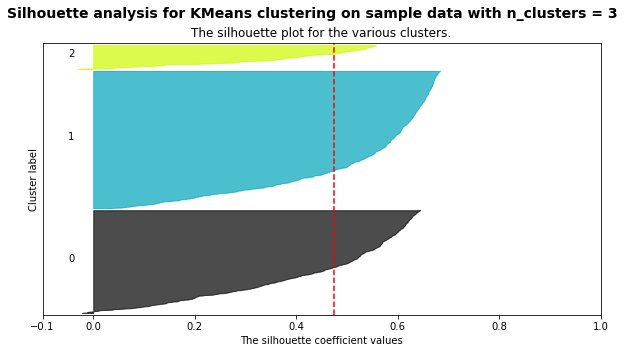

In [58]:
range_n_clusters = [3]
for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(10, 5)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(kmeans_input) + (n_clusters + 1) * 10])
    clusterer = km
    cluster_labels = km.labels_
    silhouette_avg = silhouette_score(kmeans_input, km.labels_)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    sample_silhouette_values = silhouette_samples(kmeans_input, km.labels_)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
plt.show()

Plot the clusters using TSNE

In [59]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=400, n_iter=300)
tsne_results = tsne.fit_transform(kmeans_input)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 1201 nearest neighbors...
[t-SNE] Indexed 1436 samples in 0.004s...
[t-SNE] Computed neighbors for 1436 samples in 0.316s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1436
[t-SNE] Computed conditional probabilities for sample 1436 / 1436
[t-SNE] Mean sigma: 3.785629
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.162643
[t-SNE] KL divergence after 300 iterations: 0.099277
t-SNE done! Time elapsed: 14.034922361373901 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

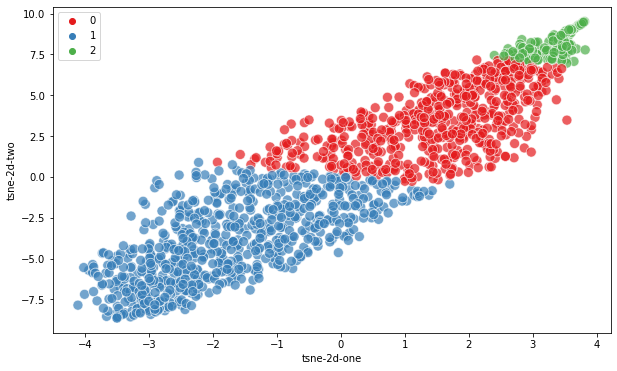

In [60]:
import seaborn as sns

standard_df =pd.DataFrame()
standard_df['tsne-2d-one'] = tsne_results[:,0]
standard_df['tsne-2d-two'] = tsne_results[:,1]
standard_df['labels'] = pd.Series(km.labels_)
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=km.labels_,
    palette='Set1',
    s=100,
    data=standard_df,
    legend="full",
    alpha=0.7
)

# Gaussian Mixture Model

As the cluster size is not equal, assumptions of KMeans are failing so we will use GMM 
GMM performs better than KMeans which gets executed on node embeddings

GMM also performs better than Louvain algorithm which is a community detection approach and is a discrete algorithm, directly runs graph object of networkx. 
This algorithm doesn’t require nodes to get converted to embedding so no deep learning on Graph is required and which actually create limitations. 

Deep Learning based cluster profiling is predictive and once embedding is created opens gate for a lot of unsupervised clustering algorithms to be used.

Louvain algorithm and Kmeans are hard clustering’s. 

While GMM is a soft clustering approach, which means say we have three clusters. So it gives probability with which a record belongs to a given cluster.
Let’s say we have prediction for Provider_1 that it belongs to Profile_0 (Low Segment) with probability 0.5 and belongs to cluster 1 (middle segment) with probability 0.4. then Provider_1 can be a good target for upselling with Cluster_1(middle segment) products, even though Provider_1 belongs to cluster_0(low segment). Such kind of analysis can be performed with Probabilistic clustering

In case of provider profiles these clusters are ordinal in nature so which means if highest probability of a record to belong to a cluster is cluster 1, then second highest probability will be cluster 2, it can not be cluster 3. So we can create custom metrics to evaluate quality of output clusters or provider profiles.

In [137]:
@torch.no_grad()
def create_cluster(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    gmm_input = z.cpu().numpy()
    gmm = GaussianMixture(n_components=3, n_init=10).fit(gmm_input)
    pred = gmm.predict(gmm_input)
    gmm.fit_predict(gmm_input)
    return gmm, gmm_input,pred

In [138]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
for epoch in range(1, 20):
    loss = train()
    gmm  = create_cluster(data)
    print((f'Epoch: {epoch:03d}, Loss: {loss:.3f}' ))

Epoch: 001, Loss: 38.811
Epoch: 002, Loss: 45.184
Epoch: 003, Loss: 49.282
Epoch: 004, Loss: 43.072
Epoch: 005, Loss: 38.394
Epoch: 006, Loss: 37.005
Epoch: 007, Loss: 36.816
Epoch: 008, Loss: 36.924
Epoch: 009, Loss: 37.387
Epoch: 010, Loss: 37.517
Epoch: 011, Loss: 37.911
Epoch: 012, Loss: 38.119
Epoch: 013, Loss: 38.561
Epoch: 014, Loss: 38.692
Epoch: 015, Loss: 38.959
Epoch: 016, Loss: 39.156
Epoch: 017, Loss: 39.270
Epoch: 018, Loss: 39.399
Epoch: 019, Loss: 39.432


In [142]:
gm = gmm[0]
gmm_input = gmm[1]
gm_label = gmm[2]

In [140]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=400, n_iter=300)
tsne_results = tsne.fit_transform(gmm_input)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 1201 nearest neighbors...
[t-SNE] Indexed 1436 samples in 0.001s...
[t-SNE] Computed neighbors for 1436 samples in 0.357s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1436
[t-SNE] Computed conditional probabilities for sample 1436 / 1436
[t-SNE] Mean sigma: 4.491379
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.452530
[t-SNE] KL divergence after 300 iterations: 0.084122
t-SNE done! Time elapsed: 15.240579843521118 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

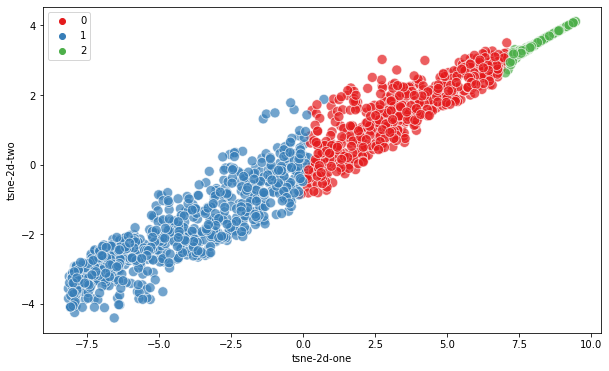

In [143]:
import seaborn as sns

standard_df =pd.DataFrame()
standard_df['tsne-2d-one'] = tsne_results[:,0]
standard_df['tsne-2d-two'] = tsne_results[:,1]
standard_df['labels'] = pd.Series(gm_label)
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=km.labels_,
    palette='Set1',
    s=100,
    data=standard_df,
    legend="full",
    alpha=0.7
)

In [145]:
set(gm_label)

{0, 1, 2}

Analyze the probability with with a provider belong to a given cluster

In [163]:
gm_probab = gm.predict_proba(gmm_input)

In [164]:
gm_probab

array([[2.33166055e-06, 7.98194111e-07, 9.99996870e-01],
       [2.20751787e-04, 9.99779248e-01, 0.00000000e+00],
       [1.38885650e-62, 1.00000000e+00, 0.00000000e+00],
       ...,
       [2.53708478e-06, 3.13435126e-09, 9.99997460e-01],
       [3.05270720e-05, 9.83180713e-01, 1.67887602e-02],
       [3.09005645e-07, 5.75258994e-14, 9.99999691e-01]])

In [168]:
gm_probab[0]

array([2.33166055e-06, 7.98194111e-07, 9.99996870e-01])

In [169]:
provider = conn.getVertexDataframe("Providers")
print(provider.shape[0])

# provider.reset_index(inplace=True)
provider['profile'] = pd.Series(gm_label)
# provider['name'] = v_id
provider.head(5)

1436


,v_id,provider_id,name,utilization,speciality,profile
0,ff3559cc-6081-3eca-a573-3adcc69f1d8e,ff3559cc-6081-3eca-a573-3adcc69f1d8e,Keneth Hansen,65,GENERAL PRACTICE,0
1,103af4d8-367d-37ca-8403-213f3bd8b98c,103af4d8-367d-37ca-8403-213f3bd8b98c,Tobie D'Amore,5,GENERAL PRACTICE,1
2,96d8d798-8ac6-3bb2-a0d3-d93ad6eecec5,96d8d798-8ac6-3bb2-a0d3-d93ad6eecec5,Vivian Stracke,17,GENERAL PRACTICE,1
3,79a46a86-8b84-38b7-a1f1-18e496e3ecbf,79a46a86-8b84-38b7-a1f1-18e496e3ecbf,Earlene Dare,40,GENERAL PRACTICE,0
4,1db57570-c37f-3c47-8c09-5321158ba35e,1db57570-c37f-3c47-8c09-5321158ba35e,Orpha O'Conner,1,GENERAL PRACTICE,0


In [148]:
provider.to_csv('prescriber_profiles.csv')

# List of Providers in Profile_0 or Lower Segment

In [149]:
print("List of provider in Profile_0 or Group_0")
provider[provider.profile == 0].name.values, len(provider[provider.profile == 0].name.values)

List of Prescibers in Profile_0 or Group_0


(array(['Keneth Hansen', 'Earlene Dare', "Orpha O'Conner", ...,
        'Spring Huel', 'Marta Bernal', 'Jed Casper'], dtype=object),
 1088)

# List of Providers in Profile_1 or Middle Segment

In [152]:
print("List of provider in Profile_1 or Group_1")
provider[provider.profile == 1].name.values, len(provider[provider.profile == 1].name.values)

List of provider in Profile_1 or Group_1


(array(["Tobie D'Amore", 'Vivian Stracke', 'Alida Moen',
        'Deirdre Satterfield', 'Karren MacGyver', 'Christian Durgan',
        'Maisie Pacocha', 'Raleigh Berge', 'Steven Gulgowski',
        'Jaime Kris', 'Dwain Cormier', 'Thea Kris', 'Granville Weissnat',
        'Kent Baumbach', 'Goldie Schultz', 'Deangelo Hackett', 'Mui Crona',
        'Xiomara Thiel', 'Mae Reinger', 'Sabrina Gottlieb',
        'Lyndsay Turner', 'Shaunda Gerlach', 'Teddy Treutel', 'Sidney Kub',
        'Maurice Dach', 'Gerardo Satterfield', 'Shari Cormier',
        'Joslyn Daniel', 'Eliseo Kassulke', 'Randal Hilpert',
        'Isiah Cummerata', 'Homero Zamora', 'Bret Champlin',
        'Óscar Rendón', 'Guillermo McDermott', 'Rochelle Fritsch',
        'Beulah Doyle', 'Herma Kreiger', 'Jacquetta Wilkinson',
        'Diedra Heidenreich', 'William Botsford', 'Arden Bernhard',
        'Mark Ullrich', 'Lazaro Sanford', 'Len Boyer', 'Missy Lakin',
        'Wilton Rath', 'China Tremblay', 'Elmo Wolf', 'Johnathon Gri

# List of Providers in Profile_2 or Higher Segment

In [153]:
print("List of provider in Profile_2 or Group_2")
provider[provider.profile == 2].name.values, len(provider[provider.profile == 2].name.values)

List of provider in Profile_2 or Group_2


(array(["Modesto O'Hara", 'Herman Schumm', 'Kory Heathcote',
        'Graham Herman', 'Zack Jones', "Bernardine O'Hara",
        'Towanda Nader', 'Zachery Mayer', 'Leopoldo Schroeder',
        'Corinna Schuppe', 'Florencia Uribe', 'Roberto Soto',
        'Richard Boehm', 'Florentino Murazik', 'Travis Fahey',
        'Valrie Grimes', 'Genia Rice', 'Bennett Williamson',
        'Agueda Cruickshank', 'Anthony Block', 'Jerry Gleichner',
        'Layla Wisozk', 'Cleotilde Bode', 'Terrence Bednar',
        'Pamelia Schamberger', 'Shonta Halvorson', 'Caleb Skiles',
        'Aja Heidenreich', 'Emile Torp', 'Garth Pouros', 'Billy Robel',
        'Bethany Senger', 'Dalia Kihn', 'Kara Bogan', 'Twyla Kozey',
        'Riley Schulist', 'Trey Hirthe', 'Jerald Ledner', 'Jocelyn Erdman',
        'Chae Littel', 'Natalie Klocko', 'Karren MacGyver',
        'Mckinley Sporer', 'Tracy McCullough', 'Avery Will',
        'Danyell Moen', 'Tonda Bernhard', 'Sterling Reichert',
        'Delilah Bogan', 'Gary Wil

# Compare predicted profile against actual profile after business Analysis

Assume that we have recieved true lables after business analysis on clusters

In [182]:
actual = pd.read_excel('prescriber_profiles_actualLabels.xlsx')

In [156]:
actual['Actual'].values

array([0, 0, 0, ..., 2, 1, 2], dtype=int64)

In [162]:
from sklearn.metrics import jaccard_score
round(jaccard_score(actual['Actual'].values, provider.profile.values, average = 'micro'),2)

0.42

In [159]:
from sklearn.metrics.cluster import pair_confusion_matrix
paired_con_matrix = pair_confusion_matrix(actual['Actual'].values, provider.profile.values)

In [160]:
TN,FP, FN, TP = paired_con_matrix[0][0], paired_con_matrix[0][1], paired_con_matrix[1][0], paired_con_matrix[1][1] 
TN,FP, FN, TP

(307952, 512040, 508696, 731972)

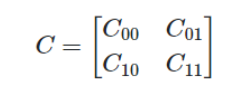

C00 : number of pairs with both clusterings having the samples not clustered together

C10 : number of pairs with the true label clustering having the samples clustered together but the other clustering not having the samples clustered together

C01 : number of pairs with the true label clustering not having the samples clustered together but the other clustering having the samples clustered together

C11 : number of pairs with both clusterings having the samples clustered together

Considering a pair of samples that is clustered together a positive pair, then as in binary classification the count of

True Negatives is C00

False Negatives is C10

True Positives is C11

False Positives is C01

# Heterogeneous Data i.e. Knowledge Graph embeddings

In [85]:
le =le.fit(provider['provider_id'])
provider['provider_id'] =  le.transform(provider['provider_id'])
providermap = provider [['v_id','provider_id']]
providermap = dict(zip(providermap.v_id,providermap.provider_id))
le =le.fit(provider['speciality'])
provider['speciality'] =  le.transform(provider['speciality'])
provider = provider [['provider_id','utilization','speciality']]
provider = provider.set_index('provider_id')
provider.head()

,utilization,speciality
provider_id,,
1427,65,13
91,5,13
855,17,13
676,40,13
168,1,13


In [86]:
from torch_geometric.data import HeteroData
data = HeteroData()
data['provider'].x = torch.Tensor([provider.utilization.values, provider.speciality.values]).t()

In [87]:
data['medication'].x = torch.Tensor([medication.medication_code.values, medication.baseCost.values,
                 medication.payerCoverage.values, medication.dispenses.values, medication.totalCost.values]).t()

data['encounter'].x = torch.Tensor([encounter.baseEncounterCost.values, encounter.totalClaimCost.values,
                 encounter.payerCoverage.values, encounter.payerCoverage.values]).t()

data['patient'].x = torch.Tensor([patient.healthcareExpense.values, patient.healthcareCoverage.values,
                 patient.birthplace.values]).t()

data['patient', 'has', 'medication'].edge_index = patient_has_medication_index

data['encounter', 'for', 'medication'].edge_index = encounter_for_medication_index

data['encounter', 'for', 'patient'].edge_index = encounter_for_patient_index

data['encounter', 'has', 'provider'].edge_index = encounter_has_provider_index

In [88]:
data['encounter', 'has', 'provider'].edge_index[0]

tensor([50367, 50253, 51108,  ...,     1,     2,     3], dtype=torch.int32)

In [89]:
data

HeteroData(
  provider={ x=[1436, 2] },
  medication={ x=[20069, 5] },
  encounter={ x=[54647, 4] },
  patient={ x=[496, 3] },
  (patient, has, medication)={ edge_index=[2, 20069] },
  (encounter, for, medication)={ edge_index=[2, 20069] },
  (encounter, for, patient)={ edge_index=[2, 54647] },
  (encounter, has, provider)={ edge_index=[2, 54647] }
)

Adding mask to Hetero Data

In [90]:
sample_arr = [True, True]
bool_arr = np.random.choice(sample_arr, size=54647)

In [91]:
train_mask = bool_arr
train_mask[20000:] = False
print(train_mask)

[ True  True  True ... False False False]


In [92]:
x=torch.Tensor(train_mask)
train_mask = torch.tensor(x, dtype=torch.bool)
train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [93]:
data['encounter'].train_mask = train_mask

In [94]:
data['encounter'].train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [95]:
test_mask = bool_arr
test_mask [:] =False
test_mask[20001:40001] = True

In [96]:
x=torch.Tensor(test_mask)
test_mask = torch.tensor(x, dtype=torch.bool)
test_mask

tensor([False, False, False,  ..., False, False, False])

In [97]:
data['encounter'].test_mask = test_mask
data['encounter'].test_mask

tensor([False, False, False,  ..., False, False, False])

In [98]:
val_mask = bool_arr
val_mask[40001:] = False

In [99]:
x=torch.Tensor(val_mask)
val_mask = torch.tensor(x, dtype=torch.bool)
val_mask

tensor([False, False, False,  ..., False, False, False])

In [100]:
data['encounter'].val_mask = val_mask

In [101]:
data

HeteroData(
  provider={ x=[1436, 2] },
  medication={ x=[20069, 5] },
  encounter={
    x=[54647, 4],
    train_mask=[54647],
    test_mask=[54647],
    val_mask=[54647]
  },
  patient={ x=[496, 3] },
  (patient, has, medication)={ edge_index=[2, 20069] },
  (encounter, for, medication)={ edge_index=[2, 20069] },
  (encounter, for, patient)={ edge_index=[2, 54647] },
  (encounter, has, provider)={ edge_index=[2, 54647] }
)

In [170]:
torch.save(data, 'HetroData.pt')

Embeddings of hetero Data can be created the sameway and followed by that clustering can be performed

# Graph Analytics using networkx

In [171]:
from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx

In [100]:
provider = conn.getVertexDataframe("Providers")
print(provider.shape[0])
provider.head(2)

1436


,v_id,provider_id,name,utilization,speciality
0,ff3559cc-6081-3eca-a573-3adcc69f1d8e,ff3559cc-6081-3eca-a573-3adcc69f1d8e,Keneth Hansen,65,GENERAL PRACTICE
1,103af4d8-367d-37ca-8403-213f3bd8b98c,103af4d8-367d-37ca-8403-213f3bd8b98c,Tobie D'Amore,5,GENERAL PRACTICE


In [101]:
nodes_to_be_added = [] 
for i in range(num_vertices):
    nodes_to_be_added.append((vertices_Provider[i].get('v_id'),(vertices_Provider[i].get('attributes'))))
G = nx.MultiDiGraph()
G.add_nodes_from(nodes_to_be_added)

In [103]:
referral_edges = pd.read_csv('referral_edges_synthea.csv')
referral_edges=referral_edges.drop('Unnamed: 0', axis=1)
referral_edges.head(2)

,from_type,from_id,to_type,to_id
0,Providers,e016cc99-2c6e-32d4-ae31-9ea77fa94281,Providers,f755b529-eb96-3ba2-8130-c2a4d4756ac7
1,Providers,c47fc513-a60a-3a77-8e3f-46e288b2c90e,Providers,9baa63d0-9eef-328a-8158-8eea300980d4


In [104]:
referral_edges['source'] = referral_edges['from_id']
referral_edges['target'] = referral_edges['to_id']

In [105]:
referral_edges= referral_edges.drop(['from_id','to_id','from_type','to_type'], axis = 1)

In [106]:
referral_edges.head()

,source,target
0,e016cc99-2c6e-32d4-ae31-9ea77fa94281,f755b529-eb96-3ba2-8130-c2a4d4756ac7
1,c47fc513-a60a-3a77-8e3f-46e288b2c90e,9baa63d0-9eef-328a-8158-8eea300980d4
2,d28c4e60-1cd3-32dc-9493-f5baff93c49f,a62bf7bc-4d9a-374d-b110-706f7a68b18f
3,610c6441-1a2a-3728-8a52-0c1a407096db,efa71c61-ff06-3633-ae37-85bdd8a4c1d4
4,1db57570-c37f-3c47-8c09-5321158ba35e,47cdb8fb-02be-3dc9-a697-5fea2f9dd7e2


In [107]:
provider.head()

,v_id,provider_id,name,utilization,speciality
0,ff3559cc-6081-3eca-a573-3adcc69f1d8e,ff3559cc-6081-3eca-a573-3adcc69f1d8e,Keneth Hansen,65,GENERAL PRACTICE
1,103af4d8-367d-37ca-8403-213f3bd8b98c,103af4d8-367d-37ca-8403-213f3bd8b98c,Tobie D'Amore,5,GENERAL PRACTICE
2,96d8d798-8ac6-3bb2-a0d3-d93ad6eecec5,96d8d798-8ac6-3bb2-a0d3-d93ad6eecec5,Vivian Stracke,17,GENERAL PRACTICE
3,79a46a86-8b84-38b7-a1f1-18e496e3ecbf,79a46a86-8b84-38b7-a1f1-18e496e3ecbf,Earlene Dare,40,GENERAL PRACTICE
4,1db57570-c37f-3c47-8c09-5321158ba35e,1db57570-c37f-3c47-8c09-5321158ba35e,Orpha O'Conner,1,GENERAL PRACTICE


In [114]:
x= provider[provider.provider_id == 'e016cc99-2c6e-32d4-ae31-9ea77fa94281'].name.values[0]
x

'Collette Langworth'

In [115]:
from_name =[]
for i in referral_edges.source.values:
    from_name.append(provider[provider.provider_id == i].name.values[0])

In [116]:
to_name =[]
for i in referral_edges.target.values:
    to_name.append(provider[provider.provider_id == i].name.values[0])

In [117]:
referral_edges['from_name'] = pd.Series(from_name)

In [118]:
referral_edges['to_name'] = to_name

In [119]:
referral_edges.source = referral_edges.from_name
referral_edges.target = referral_edges.to_name
referral_edges = referral_edges.drop(['from_name','to_name'], axis=1)
referral_edges.head(2)

,source,target
0,Collette Langworth,Lavonne Lakin
1,Glenna Kuhn,Darrin Cassin


Create Networkx Graph for insight generation and graph analysis

In [120]:
G = nx.from_pandas_edgelist(
    referral_edges,
    create_using=nx.MultiGraph(),
)

In [121]:
pd.Series(G.edges()).head()

0       (Collette Langworth, Lavonne Lakin)
1         (Collette Langworth, Dario Feest)
2      (Collette Langworth, Khalilah Mills)
3        (Collette Langworth, Romaine Veum)
4    (Collette Langworth, Diamond Mitchell)
dtype: object

In [122]:
G.number_of_edges()

5991

In [123]:
G.number_of_nodes()

1387

# Identify Bridges between profiles using Betweenness Centrality

In [124]:
nx.betweenness_centrality(G)

{'Collette Langworth': 0.0033682568122705607,
 'Lavonne Lakin': 0.001582024838788892,
 'Glenna Kuhn': 0.0021841437453897724,
 'Darrin Cassin': 0.0025950696664730267,
 'Albert Simonis': 0.000588483134847869,
 'Elmer Oberbrunner': 0.00044649886914163673,
 'Chas Williamson': 0.0019149082238127857,
 'Leola Weber': 0.00608069143374809,
 "Orpha O'Conner": 0.0021205661739521465,
 'Jordon Stamm': 0.004561020529307868,
 'Ellis Hackett': 0.0015980367277878239,
 'Dean West': 0.0007730739673273491,
 'Bettyann Cronin': 0.004838496358852719,
 'Olevia Walker': 0.0019080308466957797,
 'Jerald Ledner': 0.001044142843897028,
 'Carolynn Funk': 0.000986103304261644,
 'Bernardo Ernser': 0.001846603698956977,
 'Trish Pollich': 0.004562365982833972,
 'Alison Pfannerstill': 0.0028613958204883085,
 'Corey Bechtelar': 0.004177524303169935,
 'Mendy Schultz': 0.0010414032281489038,
 'Jen Leannon': 0.002127232482266958,
 'Emmett Kling': 0.00286242361135241,
 'Ernesto Alaniz': 0.00045359345779771507,
 'Mario White'

In [126]:
nx.degree_centrality(G)

{'Collette Langworth': 0.00937950937950938,
 'Lavonne Lakin': 0.006493506493506494,
 'Glenna Kuhn': 0.007215007215007215,
 'Darrin Cassin': 0.007936507936507936,
 'Albert Simonis': 0.004329004329004329,
 'Elmer Oberbrunner': 0.0036075036075036075,
 'Chas Williamson': 0.005772005772005772,
 'Leola Weber': 0.012987012987012988,
 "Orpha O'Conner": 0.006493506493506494,
 'Jordon Stamm': 0.00937950937950938,
 'Ellis Hackett': 0.006493506493506494,
 'Dean West': 0.004329004329004329,
 'Bettyann Cronin': 0.010822510822510822,
 'Olevia Walker': 0.006493506493506494,
 'Jerald Ledner': 0.00505050505050505,
 'Carolynn Funk': 0.00505050505050505,
 'Bernardo Ernser': 0.006493506493506494,
 'Trish Pollich': 0.0101010101010101,
 'Alison Pfannerstill': 0.007936507936507936,
 'Corey Bechtelar': 0.00937950937950938,
 'Mendy Schultz': 0.00505050505050505,
 'Jen Leannon': 0.007215007215007215,
 'Emmett Kling': 0.007936507936507936,
 'Ernesto Alaniz': 0.0036075036075036075,
 'Mario White': 0.00505050505050

# Identify most influential providers for entire population as well as across provider profiles using voterank

In [127]:
nx.voterank(G)

['Tracey Walsh',
 'María Elena Concepción',
 'Suzann Hilpert',
 'Tana Rice',
 'Jamey Fisher',
 'Lazaro Lueilwitz',
 'Missy Lakin',
 'Bret Champlin',
 'Russ Hahn',
 'Willetta Gleason',
 'Gema Tremblay',
 'Hope Moore',
 'Jean Altenwerth',
 'Guillermo McDermott',
 'Winston Carroll',
 'Morris Bruen',
 'Aurelio Adams',
 'Raymundo Reilly',
 'Robbi Barton',
 'Antione Wyman',
 'Quincy McLaughlin',
 'Shameka Bayer',
 'Perry Romaguera',
 'Roberto Soto',
 'Leola Weber',
 'Zackary Cruickshank',
 'Floy Heller',
 'France Blanda',
 'Belen Kerluke',
 'Lynelle Rippin',
 'Dino Pouros',
 'Philip Rolfson',
 'Ivette Sanford',
 'Carmen Reichel',
 'Clinton Crist',
 'Gabriel Rippin',
 'Kristofer Bayer',
 'Romaine Veum',
 'Lonny Jacobson',
 'Laraine Morar',
 'Erich Hills',
 'Maurice Dach',
 'Nila Gaylord',
 'Cleveland Haley',
 'Lauren Rowe',
 'Beulah Doyle',
 'Gladis Lindgren',
 'Meghann Hilll',
 'Ramonita Walsh',
 'Haywood Rodriguez',
 'Ernie Wiegand',
 'Mose Braun',
 'Tamra Keebler',
 'Willie Bernier',
 'Kar

# Identify small groups of providers using cliques

In [129]:
cliques = list(nx.enumerate_all_cliques(G))
nx.number_of_cliques(G)

{'Collette Langworth': 12,
 'Lavonne Lakin': 9,
 'Glenna Kuhn': 10,
 'Darrin Cassin': 11,
 'Albert Simonis': 6,
 'Elmer Oberbrunner': 5,
 'Chas Williamson': 8,
 'Leola Weber': 17,
 "Orpha O'Conner": 8,
 'Jordon Stamm': 13,
 'Ellis Hackett': 9,
 'Dean West': 6,
 'Bettyann Cronin': 15,
 'Olevia Walker': 8,
 'Jerald Ledner': 7,
 'Carolynn Funk': 7,
 'Bernardo Ernser': 9,
 'Trish Pollich': 14,
 'Alison Pfannerstill': 11,
 'Corey Bechtelar': 12,
 'Mendy Schultz': 7,
 'Jen Leannon': 10,
 'Emmett Kling': 11,
 'Ernesto Alaniz': 5,
 'Mario White': 7,
 'Jacquline Kemmer': 7,
 'Rana McCullough': 12,
 'Carlo Stokes': 3,
 'Suzann Hilpert': 22,
 'Rick Ruecker': 10,
 'Russ Stracke': 11,
 'Juliane Treutel': 3,
 'Reggie Ebert': 8,
 'Rolland Crooks': 8,
 'Chae Littel': 7,
 'Doyle Wunsch': 11,
 'Celestina Crona': 7,
 'Monserrate Lang': 4,
 'Dannielle Toy': 12,
 'Jeremiah Labadie': 8,
 'Elliot Sporer': 12,
 'Wendell Waelchi': 9,
 'Rivka Hills': 14,
 'Sandra Stanton': 8,
 'Gil Aufderhar': 6,
 'Gabriela Sar

Identify Dominating set of Providers

In [249]:
len(nx.dominating_set(G))

378

louvain communities can be identified using networkx but the performance is very slow and not useful for provider profiling

In [183]:
# nx_comm.louvain_communities(G, seed=123)